## RFM Analysis

In [1]:
import pandas as pd
import numpy as np
# Input data files are available in the "../input/" directory.

import time, warnings
import datetime as dt

#visualizations
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

warnings.filterwarnings("ignore")

In [2]:
retail_df=pd.read_csv("C:\\Users\\MRAVI\\Desktop\\RFM\\RFMData.csv")

In [3]:
retail_df.head()

,ID,SKU_ID,ChannelID,CustID,OrderID,OrderDate,Quantity,Amount,Channel,Category
0,1,459,3,134945,326324.0,04-03-2006,1,18.0,web1,G
1,2,459,4,212174,109305.0,16-05-2007,2,36.0,web2,G
2,3,459,3,39861,172669.0,06-06-2007,1,18.0,web1,G
3,4,459,3,11227,132642.0,30-04-2007,3,54.0,web1,G
4,5,459,3,137271,20449.0,10-05-2007,1,18.0,web1,G


In [4]:
retail_df.describe()

,ID,SKU_ID,ChannelID,CustID,OrderID,Quantity,Amount
count,541101.000000,541101.000000,541101.000000,541101.000000,541097.000000,541101.000000,541101.000000
mean,270551.000000,343.823305,3.086228,152974.428942,207534.987178,1.112728,31.810787
std,156202.548342,242.233469,0.487570,134607.729555,116969.497967,0.771844,22.963229
min,1.000000,2.000000,1.000000,2.000000,2.000000,0.000000,0.010000
25%,135276.000000,126.000000,3.000000,62221.000000,105292.000000,1.000000,20.000000
50%,270551.000000,322.000000,3.000000,124343.000000,210908.000000,1.000000,30.000000
75%,405826.000000,492.000000,3.000000,185119.000000,315711.000000,1.000000,35.000000
max,541101.000000,1231.000000,4.000000,506929.000000,388319.000000,275.000000,4577.000000


In [5]:
print("Summary:")
print("Number of transactions: ", retail_df['OrderID'].nunique())
print("Number of customers:", retail_df['CustID'].nunique() )
print("Number of channels:", retail_df['ChannelID'].nunique())
print("Number of Product categories:", retail_df['Category'].nunique())
print("Number of products : ",retail_df['SKU_ID'].nunique())
print("Percentage of customers NA: ", round(retail_df['CustID'].isnull().sum() * 100 / len(retail_df),2),"%" )

Summary:
Number of transactions:  263665
Number of customers: 134984
Number of channels: 4
Number of Product categories: 6
Number of products :  763
Percentage of customers NA:  0.0 %


### Recency

In [6]:
#last date available in our dataset
retail_df['OrderDate'].max()

'31-12-2007'

In [7]:
now = dt.date(2007,12,31)
print(now)

2007-12-31


##### The last date we have is 2007-12-31 so we will use it as reference.

In [8]:
retail_df['date'] = pd.DatetimeIndex(retail_df['OrderDate']).date

In [9]:
retail_df.head()

,ID,SKU_ID,ChannelID,CustID,OrderID,OrderDate,Quantity,Amount,Channel,Category,date
0,1,459,3,134945,326324.0,04-03-2006,1,18.0,web1,G,2006-04-03
1,2,459,4,212174,109305.0,16-05-2007,2,36.0,web2,G,2007-05-16
2,3,459,3,39861,172669.0,06-06-2007,1,18.0,web1,G,2007-06-06
3,4,459,3,11227,132642.0,30-04-2007,3,54.0,web1,G,2007-04-30
4,5,459,3,137271,20449.0,10-05-2007,1,18.0,web1,G,2007-10-05


In [10]:
#group by customers and check last date of purshace
recency_df = retail_df.groupby(by='CustID', as_index=False)['date'].max()
recency_df.columns = ['CustID','LastPurshaceDate']
recency_df.head()

,CustID,LastPurshaceDate
0,2,2007-11-25
1,3,2006-12-28
2,6,2007-05-04
3,7,2008-02-29
4,11,2007-04-07


In [11]:
#calculate recency
recency_df['Recency'] = recency_df['LastPurshaceDate'].apply(lambda x: (now - x).days)

In [12]:
recency_df.head()

,CustID,LastPurshaceDate,Recency
0,2,2007-11-25,36
1,3,2006-12-28,368
2,6,2007-05-04,241
3,7,2008-02-29,-60
4,11,2007-04-07,268


In [13]:
#drop LastPurchaseDate as we don't need it anymore
recency_df.drop('LastPurshaceDate',axis=1,inplace=True)

### Frequency

In [14]:
#calculate frequency of purchases
frequency_df = retail_df.groupby(by=['CustID'], as_index=False)['OrderID'].count()
frequency_df.columns = ['CustID','Frequency']
frequency_df.head()

,CustID,Frequency
0,2,1
1,3,1
2,6,5
3,7,2
4,11,2


### Monetary

In [15]:
#create column total cost
retail_df['TotalCost'] = retail_df['Quantity'] * retail_df['Amount']

In [16]:
monetary_df = retail_df.groupby(by='CustID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustID','Monetary']
monetary_df.head()

,CustID,Monetary
0,2,55.0
1,3,20.0
2,6,135.0
3,7,125.0
4,11,34.0


## RFM Table

In [17]:
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='CustID')
temp_df.head()

,CustID,Recency,Frequency
0,2,36,1
1,3,368,1
2,6,241,5
3,7,-60,2
4,11,268,2


In [18]:
#merge with monetary dataframe to get a table with the 3 columns
rfm_df = temp_df.merge(monetary_df,on='CustID')
#use CustomerID as index
rfm_df.set_index('CustID',inplace=True)
#check the head
rfm_df.head()

,Recency,Frequency,Monetary
CustID,,,
2,36,1,55.0
3,368,1,20.0
6,241,5,135.0
7,-60,2,125.0
11,268,2,34.0


In [19]:
#Customer segments with RFM Model

In [20]:
quantiles = rfm_df.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary
0.25,-57.0,1.0,36.0
0.50,149.0,2.0,77.0
0.75,400.0,4.0,163.0


In [21]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [22]:
#create rfm segmentation table
rfm_segmentation = rfm_df
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles,))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles,))

In [23]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile
CustID,,,,,,
2,36,1,55.0,3,1,2
3,368,1,20.0,2,1,1
6,241,5,135.0,2,4,3
7,-60,2,125.0,4,2,3
11,268,2,34.0,2,2,1


For analysis it is critical to combine the scores to create a single score. There are few approaches. One approach is to just concatenate the scores to create a 3 digit number between 111 and 444. Here the drawback is too many categories (4x4x4). Also, not easy prioritise scores like 421 vs 412.

In [24]:
rfm_segmentation['RFMScore'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustID,,,,,,,
2,36,1,55.0,3,1,2,312
3,368,1,20.0,2,1,1,211
6,241,5,135.0,2,4,3,243
7,-60,2,125.0,4,2,3,423
11,268,2,34.0,2,2,1,221


In [25]:
rfm_segmentation.sort_values(by=['RFMScore', 'Monetary'], ascending=[True, False])

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore
CustID,,,,,,,
1537,452,1,36.00,1,1,1,111
2732,482,1,36.00,1,1,1,111
2912,695,1,36.00,1,1,1,111
2938,506,1,36.00,1,1,1,111
5329,585,1,36.00,1,1,1,111
5705,523,1,36.00,1,1,1,111
5905,544,1,36.00,1,1,1,111
11513,605,1,36.00,1,1,1,111
12434,534,1,36.00,1,1,1,111


In [26]:
rfm_segmentation.groupby('RFMScore').agg('Monetary').mean()

RFMScore
111      25.671357
112      50.999629
113     114.684892
114    4726.971751
121      30.680105
122      56.603786
123     101.221591
124     573.421182
131      33.136364
132      62.238850
133     109.575503
134     405.712861
142      69.468750
143     129.234907
144     382.663195
211      25.411758
212      50.490869
213     110.104294
214     589.238845
221      30.228195
222      56.207477
223     100.910488
224     360.155875
231      32.418605
232      62.662799
233     108.538888
234     453.733333
242      68.451613
243     129.692404
244     497.663121
311      24.899468
312      49.799855
313     101.597171
314     646.136905
321      30.071839
322      56.520343
323     103.486284
324     589.584567
331      32.558824
332      61.829075
333     109.962395
334     345.300079
342      69.701754
343     128.363557
344     472.809934
411      25.063164
412      50.189236
413     103.142664
414     453.397959
421      29.175145
422      58.149857
423     103.032039
424

Another possibility is to combine the scores to create one score (eg. 4+1+1). This will create a score between 3 and 12.

In [27]:
rfm_segmentation['Total Score'] = rfm_segmentation['R_Quartile'] + rfm_segmentation['F_Quartile'] +rfm_segmentation['M_Quartile']
print(rfm_segmentation.head(), rfm_segmentation.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134984 entries, 2 to 506929
Data columns (total 8 columns):
Recency        134984 non-null int64
Frequency      134984 non-null int64
Monetary       134984 non-null float64
R_Quartile     134984 non-null int64
F_Quartile     134984 non-null int64
M_Quartile     134984 non-null int64
RFMScore       134984 non-null object
Total Score    134984 non-null int64
dtypes: float64(1), int64(6), object(1)
memory usage: 9.3+ MB
        Recency  Frequency  Monetary  R_Quartile  F_Quartile  M_Quartile  \
CustID                                                                     
2            36          1      55.0           3           1           2   
3           368          1      20.0           2           1           1   
6           241          5     135.0           2           4           3   
7           -60          2     125.0           4           2           3   
11          268          2      34.0           2           2           1 

In [28]:
rfm_segmentation.groupby('Total Score').agg('Monetary').mean()

Total Score
3      25.671357
4      31.196639
5      42.283401
6     158.134463
7     101.229622
8     130.677818
9     229.670482
10    314.372807
11    389.963154
12    557.387640
Name: Monetary, dtype: float64

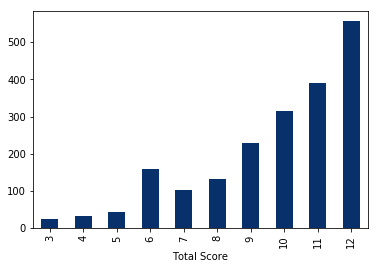

In [29]:
rfm_segmentation.groupby('Total Score').agg('Monetary').mean().plot(kind='bar', colormap='Blues_r')

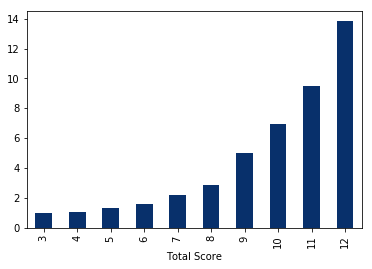

In [30]:
rfm_segmentation.groupby('Total Score').agg('Frequency').mean().plot(kind='bar', colormap='Blues_r')

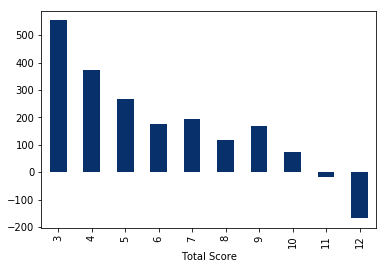

In [31]:
rfm_segmentation.groupby('Total Score').agg('Recency').mean().plot(kind='bar', colormap='Blues_r')


In [32]:
#Best Recency score = 4: most recently purchase. Best Frequency score = 4: most quantity purchase. Best Monetary score = 4: spent the most.

In [33]:
#Let's see who are our best customers.

In [34]:
rfm_segmentation[rfm_segmentation['RFMScore']=='444'].sort_values('Monetary', ascending=False).head(20)

,Recency,Frequency,Monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,Total Score
CustID,,,,,,,,
29095,-340,262,80856.00,4,4,4,444,12
73528,-216,124,53517.00,4,4,4,444,12
487715,-155,17,38832.00,4,4,4,444,12
157054,-342,196,33666.32,4,4,4,444,12
116193,-176,52,13082.50,4,4,4,444,12
156302,-312,240,13005.00,4,4,4,444,12
501037,-152,6,12649.00,4,4,4,444,12
91595,-220,25,9172.00,4,4,4,444,12
28342,-158,81,8807.00,4,4,4,444,12


In [35]:
#How many customers do we have in each segment?

In [36]:
print("High Valued Customers: ",len(rfm_segmentation[rfm_segmentation['RFMScore']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("High Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFMScore']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='144']))
print('Lost low value Customers: ',len(rfm_segmentation[rfm_segmentation['RFMScore']=='111']))

High Valued Customers:  8853
Loyal Customers:  33025
High Spenders:  33626
Almost Lost:  5735
Lost Customers:  4513
Lost low value Customers:  9381
